In [5]:
!pip install squarify


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import time
import datetime
import squarify

# Data preprocessing

## Data Import and Cleaning


- Import data
- Understand general structure
- Manage nulls
- Manage duplicated
- Manage outliers
- Manage cancelled orders

In [7]:
data = pd.read_csv('data/online_retail_II.csv')

In [8]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [10]:
data.isna().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

Missing descriptions are irrelevant as this data won't be used.

Missing customer ID's should be removed as this is essential data to our customer segmentation analysis. Although it should be notes that almost 1/4 of invoices have no customer ID - this should be looked into during data collection.


In [11]:
missing_customers_mask = data['Customer ID'].isna()
data_cl = data[~missing_customers_mask]

In [12]:
data_cl.duplicated().sum()

26479

There seems to be almost 26500 lines which are exactly duplicated. For the moment we are assuming that these are valid and the customer has added two sets of the same items to the same orders, leading to exactly duplicate lines. This accounts for just over 3% of orders so could be . Should be investigated further.

Managing outliers

In [13]:
data_cl.describe()

,Quantity,Price,Customer ID
count,824364.000000,824364.000000,824364.000000
mean,12.414574,3.676800,15324.638504
std,188.976099,70.241388,1697.464450
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13975.000000
50%,5.000000,1.950000,15255.000000
75%,12.000000,3.750000,16797.000000
max,80995.000000,38970.000000,18287.000000


In [14]:
data_cl[data_cl['Quantity']<0].count()

Invoice        18744
StockCode      18744
Description    18744
Quantity       18744
InvoiceDate    18744
Price          18744
Customer ID    18744
Country        18744
dtype: int64

In [15]:
data_cl[data_cl['Quantity']<0]['Invoice'].str.contains("C", na=False).sum()

18744

All invoices with negative quantities (18744 lines) are 'cancelled' orders and are therefore accurate as having negative values.

In [16]:
data_cl[data_cl['Price'] <= 0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
4674,489825,22076,6 RIBBONS EMPIRE,12,2009-12-02 13:34:00,0.0,16126.0,United Kingdom
6781,489998,48185,DOOR MAT FAIRY CAKE,2,2009-12-03 11:19:00,0.0,15658.0,United Kingdom
16107,490727,M,Manual,1,2009-12-07 16:38:00,0.0,17231.0,United Kingdom
18738,490961,22065,CHRISTMAS PUDDING TRINKET POT,1,2009-12-08 15:25:00,0.0,14108.0,United Kingdom
18739,490961,22142,CHRISTMAS CRAFT WHITE FAIRY,12,2009-12-08 15:25:00,0.0,14108.0,United Kingdom
...,...,...,...,...,...,...,...,...
1004540,577129,22464,HANGING METAL HEART LANTERN,4,2011-11-17 19:52:00,0.0,15602.0,United Kingdom
1005014,577168,M,Manual,1,2011-11-18 10:42:00,0.0,12603.0,Germany
1006110,577314,23407,SET OF 2 TRAYS HOME SWEET HOME,2,2011-11-18 13:23:00,0.0,12444.0,Norway
1011446,577696,M,Manual,1,2011-11-21 11:57:00,0.0,16406.0,United Kingdom


71 free orders and no orders less than 0 price - outliers have been investigated and managed.

## Cancelled orders

Data information:

Invoice - if this starts with a 'C' it was a cancellation.

In [17]:
data2 = data_cl

In [18]:
data2['Invoice'][data2['Invoice'].str.contains("C", na=False)]

178        C489449
179        C489449
180        C489449
181        C489449
182        C489449
            ...   
1065910    C581490
1067002    C581499
1067176    C581568
1067177    C581569
1067178    C581569
Name: Invoice, Length: 18744, dtype: object

In [19]:
data2[data2['Invoice'] == 'C489449']

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
183,C489449,21871,SAVE THE PLANET MUG,-12,2009-12-01 10:33:00,1.25,16321.0,Australia
184,C489449,84946,ANTIQUE SILVER TEA GLASS ETCHED,-12,2009-12-01 10:33:00,1.25,16321.0,Australia
185,C489449,84970S,HANGING HEART ZINC T-LIGHT HOLDER,-24,2009-12-01 10:33:00,0.85,16321.0,Australia
186,C489449,22090,PAPER BUNTING RETRO SPOTS,-12,2009-12-01 10:33:00,2.95,16321.0,Australia


In [20]:
data2[data2['Customer ID'] == 16321.0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
183,C489449,21871,SAVE THE PLANET MUG,-12,2009-12-01 10:33:00,1.25,16321.0,Australia
184,C489449,84946,ANTIQUE SILVER TEA GLASS ETCHED,-12,2009-12-01 10:33:00,1.25,16321.0,Australia
185,C489449,84970S,HANGING HEART ZINC T-LIGHT HOLDER,-24,2009-12-01 10:33:00,0.85,16321.0,Australia
186,C489449,22090,PAPER BUNTING RETRO SPOTS,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
187,489450,22087,PAPER BUNTING WHITE LACE,12,2009-12-01 10:36:00,2.95,16321.0,Australia


From investigation into a specific customer, it seems that cancelled orders are negative and shouldn't be excluded as they are negatively balancing the previous order. This should be accounted for due to some customers having supposedly large orders but not in reality due to the cancellation.

# Data Organising 

- Apply data types

- Feature engineering

- Scale Data

- Engineer Features

Data Types:

- Invoice - String. Due to cancelled orders still being included.

- StockCode - Integer. Letters seem to signify different variations on an items so can be split into a new feature (or disregarded if they have the same price)

- Quantity - Integer

- InvoiceDate - Datetime

- Price - Float

- Customer ID - Integer

- Country - String/ Object


## Invoices

In [21]:
data2 = data2.astype({'Invoice':'str'})

## Stock Codes

Splitting letters from Stock Codes to isolate item groups (even with variations).

Not strictly necessary for customer segmentation but a useful exercise into applying functions and analysing item popularity.

In [22]:
def split_end_letters(x):
    y = ''
    if x.isalpha():
        return x
    for i in x[::-1]:
        if i.isalpha():
            y += i
        else:
            return y[::-1]
    return y[::-1]

def stock_numeric_func(x):
    if x.isalpha():
        return 0
    while not x.isnumeric():
        if x[-1].isalpha():
            x = x[:-1]
        else:
            return x + 'problem'
    return x

In [23]:
start = time.time()
data2['stock_num'] = data2['StockCode'].apply(stock_numeric_func)
data2['stock_str'] = data2['StockCode'].apply(split_end_letters)
end = time.time()
print(end - start)

0.7631344795227051


In [24]:
data2.drop(columns = 'StockCode', inplace = True)

## Other features

In [25]:
data2 = data2.astype({'Description' : 'str', 'Quantity' : 'int32', 'Price' : 'float32', 'Customer ID' : 'int32', 'Country' : 'str'})

In [26]:
data2['InvoiceDate'] = pd.to_datetime(data2['InvoiceDate'])

Changing names of columns for sanity's sake

In [27]:
data2.rename(columns = {'Invoice' : 'invoice', 'Description':'description', 
                        'Quantity':'quantity', 'InvoiceDate':'invoice_date','Price':'price',
                        'Customer ID':'customer_id','Country':'country'}, inplace = True)

In [28]:
data2.head()

,invoice,description,quantity,invoice_date,price,customer_id,country,stock_num,stock_str
0,489434,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,85048,
1,489434,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,79323,P
2,489434,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,79323,W
3,489434,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,22041,
4,489434,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,21232,


In [29]:
data2['total_price'] = data2['quantity']*data2['price']

In [30]:
data2.to_csv('data/preprocessed_online_retail_II.csv', index = False)

## Feature Engineering

We need to create the following for RFM:

- Recency score

- Frequency score

- Monetary score


And the scale is defined by:

1 – 3 scale for less than 30k customers;

1 – 4 scale for 30k – 200k customers;

1 – 5 scale for more than 200k customers.

Therefore given we only have 6000 customers we would usually use a sclae of 1-3. However to practice for larger dataset we are using the scale from 1-5 still.

Make 'recency' column indicating how recent the purchase was

In [31]:
now = data2['invoice_date'].iloc[-1]

In [32]:
data2['recency'] = (now-data2['invoice_date']).dt.round('D')

In [34]:
data2['recency']

0         738 days
1         738 days
2         738 days
3         738 days
4         738 days
            ...   
1067366     0 days
1067367     0 days
1067368     0 days
1067369     0 days
1067370     0 days
Name: recency, Length: 824364, dtype: timedelta64[ns]

In [35]:
data2[data2['customer_id'] == 12382]

,invoice,description,quantity,invoice_date,price,customer_id,country,stock_num,stock_str,total_price,recency
70987,C495743,Adjustment by john on 26/01/2010 16,-1,2010-01-26 16:25:00,18.379999,12382,Netherlands,0,ADJUST,-18.379999,682 days


Now group by invoice

In [36]:
customer_data = data2.groupby(by = 'customer_id').agg({'recency':'min',
                                                       'invoice':lambda x: x.nunique(),
                                                       'total_price':'sum',
                                                       })

In [37]:
customer_data

,recency,invoice,total_price
customer_id,,,
12346,325 days,17,-64.680001
12347,2 days,8,5633.319988
12348,75 days,5,2019.400000
12349,18 days,5,4404.539981
12350,310 days,1,334.399997
...,...,...,...
18283,3 days,22,2736.649978
18284,429 days,2,436.679998
18285,660 days,1,426.999994


Removing customers with less than 0 lifetime price as they are due to test products, random refunds etc.

In [38]:
customer_data = customer_data[customer_data['total_price']>0]

In [39]:
customer_data.columns = ['recency','frequency','monetary']

array([[<AxesSubplot:title={'center':'frequency'}>,
        <AxesSubplot:title={'center':'monetary'}>]], dtype=object)

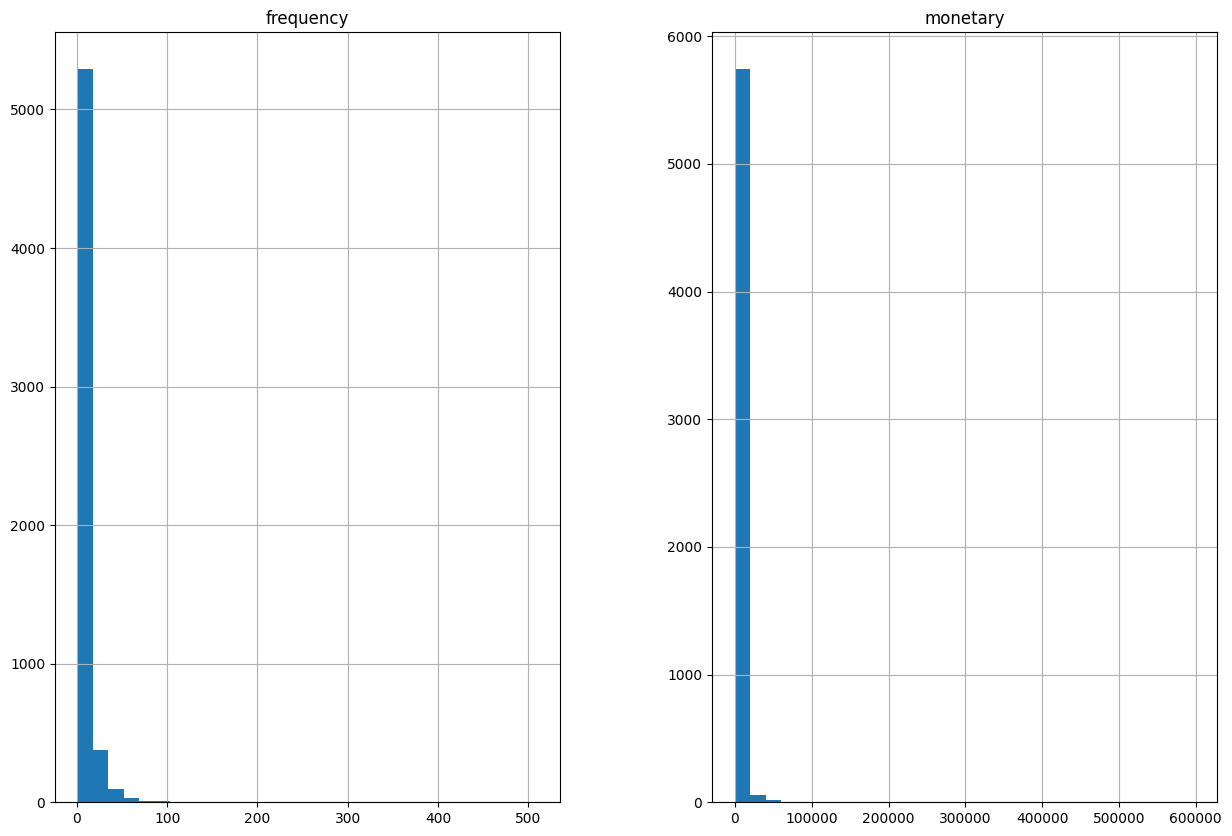

In [40]:
customer_data[['recency','frequency','monetary']].hist(bins=30, figsize=(15, 10))

In [41]:
customer_data["recency_score"] = pd.qcut(customer_data['recency'], 5, labels=[5,4,3,2,1])
customer_data["frequency_score"] = pd.qcut(customer_data['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
customer_data["monetary_score"] = pd.qcut(customer_data['monetary'], 5, labels=[1,2,3,4,5])

/tmp/ipykernel_29204/267888422.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_data["recency_score"] = pd.qcut(customer_data['recency'], 5, labels=[5,4,3,2,1])
/tmp/ipykernel_29204/267888422.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_data["frequency_score"] = pd.qcut(customer_data['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
/tmp/ipykernel_29204/267888422.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [42]:
customer_data["RFM_score"] = (customer_data['recency_score'].astype(str) +
                   customer_data['frequency_score'].astype(str))

/tmp/ipykernel_29204/2409607397.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_data["RFM_score"] = (customer_data['recency_score'].astype(str) +


In [43]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_risk',
    r'[1-2]5': 'cant_lose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalist',
    r'5[4-5]': 'champions'
}

In [44]:
customer_data['classification'] = customer_data['RFM_score'].replace(seg_map, regex=True)

/tmp/ipykernel_29204/1014002729.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_data['classification'] = customer_data['RFM_score'].replace(seg_map, regex=True)


In [45]:
customer_data.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_score,classification
customer_id,,,,,,,,
12347,2 days,8,5633.319988,5,4,5,54,champions
12348,75 days,5,2019.400000,3,3,4,33,need_attention
12349,18 days,5,4404.539981,5,3,5,53,potential_loyalist
12350,310 days,1,334.399997,2,1,2,21,hibernating
12351,375 days,1,300.929998,2,1,2,21,hibernating


In [46]:
customer_data[["classification", "recency", "frequency", "monetary"]].groupby("classification").agg(["mean", "count"])

recency        frequency        \
                                          mean count       mean count   
classification                                                          
about_to_sleep     102 days 11:01:43.394255875   383   1.493473   383   
at_Risk            365 days 14:20:33.466135460   753   4.783533   753   
cant_loose         305 days 13:16:14.117647060    85  17.976471    85   
champions            7 days 12:37:10.985915493   852  23.619718   852   
hibernating        454 days 18:41:23.422459896  1496   1.365642  1496   
loyal_customers     64 days 04:11:13.381294964  1112  12.087230  1112   
need_attention     107 days 17:45:29.670329670   273   3.747253   273   
new_customers        9 days 23:08:34.285714285    56   1.000000    56   
potential_loyalist  23 days 17:53:29.457579972   719   2.998609   719   
promising           36 days 11:40:11.009174312   109   1.000000   109   

                        monetary        
                            mean count  
classification                          
about_to_sleep        510.564598   383  
at_Risk              1255.089186   753  
cant_loose           5799.201041    85  
champions           10552.624800   852  
hibernating           404.270655  1496  
loyal_customers      4044.093349  1112  
need_attention       1105.627031   273  
new_customers         363.759999    56  
potential_loyalist    916.720232   719  
promising             320.040641   109

In [47]:
customer_data[customer_data["classification"] == "need_attention"].head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_score,classification
customer_id,,,,,,,,
12348,75 days,5,2019.400000,3,3,4,33,need_attention
12379,81 days,5,1618.269994,3,3,4,33,need_attention
12418,112 days,5,2016.949970,3,3,4,33,need_attention
12434,84 days,5,1062.479991,3,3,3,33,need_attention
12458,71 days,4,1777.489995,3,3,4,33,need_attention


In [48]:
new_df = pd.DataFrame()
new_df["new_customer_id"] = customer_data[customer_data["classification"] == "need_attention"].index
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   new_customer_id  273 non-null    int64
dtypes: int64(1)
memory usage: 2.3 KB


Now creating a pipeline function for new data, as customers can change between classifications due to spending habits

In [49]:
def create_rfm(data):

    # PREPARING THE DATA
    missing_customers_mask = data['Customer ID'].isna()
    data = data[~missing_customers_mask]
    data = data.astype({'Description' : 'str', 
                          'Quantity' : 'int32', 
                          'Price' : 'float32', 
                          'Customer ID' : 'int32', 
                          'Country' : 'str'})
    data.rename(columns = {'Invoice' : 'invoice', 
                           'Description':'description', 
                           'Quantity':'quantity', 
                           'InvoiceDate':'invoice_date',
                           'Price':'price',
                           'Customer ID':'customer_id',
                           'Country':'country'}, inplace = True)
    data['total_price'] = data['quantity']*data['price']

    # CALCULATION OF RFM metrics
    most_recent_date = data2['invoice_date'].iloc[-1]
    customer_data = data2.groupby(by = 'customer_id').agg({'recency':'min',
                                                       'invoice':lambda x: x.nunique(),
                                                       'total_price':'sum',
                                                       })
    customer_data = customer_data[customer_data['total_price']>0]
    customer_data.columns = ['recency', 'frequency', "monetary"]

    # CALCULATION OF RFM SCORES
    customer_data["recency_score"] = pd.qcut(customer_data['recency'], 5, labels=[5,4,3,2,1])
    customer_data["frequency_score"] = pd.qcut(customer_data['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
    customer_data["monetary_score"] = pd.qcut(customer_data['monetary'], 5, labels=[1,2,3,4,5])

    # cltv_df scores converted to categorical value and added to df
    customer_data["RFM_score"] = (customer_data['recency_score'].astype(str) +
                   customer_data['frequency_score'].astype(str))

    # NAMING OF SEGMENTS
    seg_map = {
        r'[1-2][1-2]': 'hibernating',
        r'[1-2][3-4]': 'at_risk',
        r'[1-2]5': 'cant_lose',
        r'3[1-2]': 'about_to_sleep',
        r'33': 'need_attention',
        r'[3-4][4-5]': 'loyal_customers',
        r'41': 'promise',
        r'51': 'new_customers',
        r'[4-5][2-3]': 'potential_loyalists',
        r'5[4-5]': 'champions'
    }

    customer_data['classification'] = customer_data['RFM_score'].replace(seg_map, regex=True)
    customer_data = customer_data[["recency", "frequency", "monetary", "segment"]]
    return customer_data

In [77]:
customer_data.reset_index(inplace = True)

In [78]:
sq1 = customer_data.groupby(by='classification').count()['customer_id'].sort_values(ascending=False).reset_index()

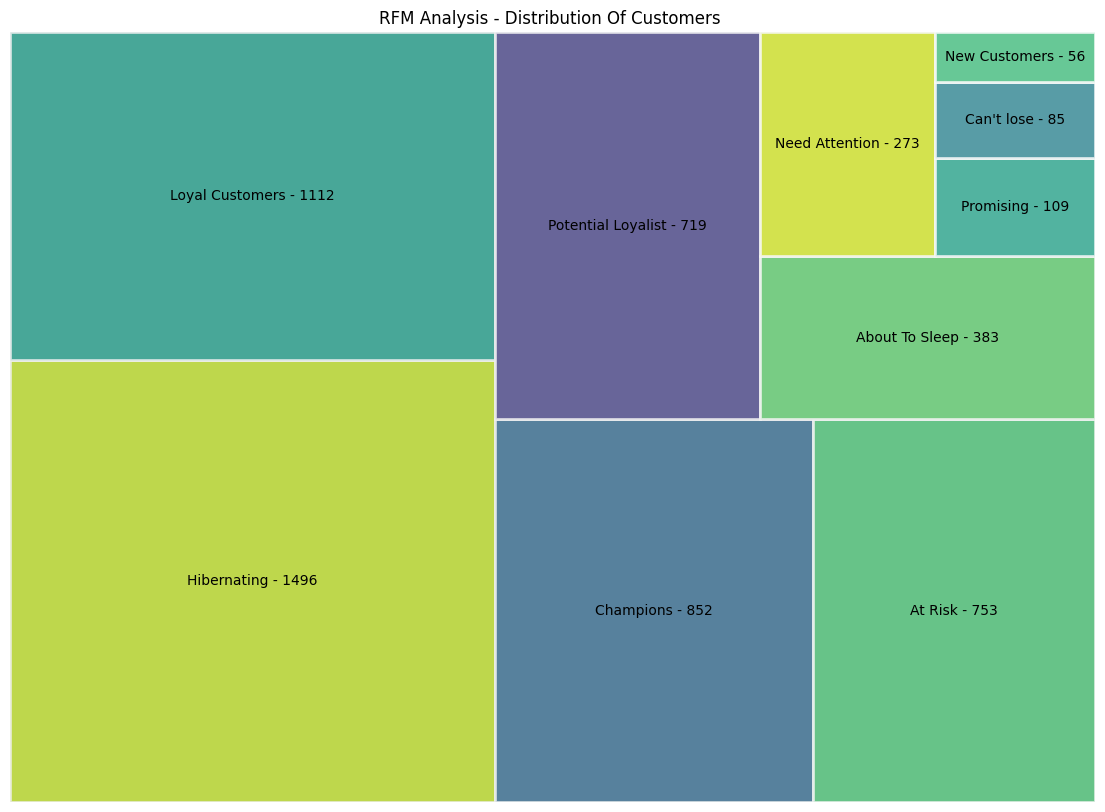

In [138]:
cmap = matplotlib.cm.coolwarm
mini = min(sq1['customer_id'])
maxi = max(sq1['customer_id'])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colours = [[i/10,i/10,i/10,1] for i in range(10)]
colors = [cmap(norm(value)) for value in sq1['customer_id']]
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14,10)
labels = [sq1['customer_id'][i] for i in range(10)]
squarify.plot(sizes=sq1['customer_id'], alpha=.8, edgecolor="white", linewidth=2)
squarify.plot(sizes=sq1['customer_id'],
             label=[f'Hibernating - {labels[0]}',f'Loyal Customers - {labels[1]}',
                    f'Champions - {labels[2]}',f'At Risk - {labels[3]}',
                    f'Potential Loyalist - {labels[4]}',f'About To Sleep - {labels[5]}',
                    f'Need Attention - {labels[6]}', f'Promising - {labels[7]}',
                    f"Can't lose - {labels[8]}",f'New Customers - {labels[9]}'], 
                    alpha=0.06, color=colours)

plt.axis('off')
plt.title('RFM Analysis - Distribution Of Customers ')
plt.show()